In [1]:
## Import methods
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)
from pandas.tools.plotting import scatter_matrix
from scipy import stats


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Pipeline-ish
- read data into dataframe
- replace NaNs with zeros
- PCA down to 2 features

In [2]:
class Process_Data(object):
    '''Process data for clustering

    load the data into a datafram
    replace Nans with zeros
    repalce
    pca/lstne down, put results in a different dataframe

    '''

    def __init__(self, filepath=None):
        self.filepath = filepath
        self.df = pd.DataFrame([])
        self.df_pca = pd.DataFrame([])
        self.df_tsne = pd.DataFrame([])

    def _load_data(self):
        self.df = pd.read_csv(self.filepath, sep='\t')

    def _format_data(self):
        #replace Nans with zeros
        self.df.fillna(0, inplace=True)
        #make a column with rolling4Q sum
        self.df['R4Q Total'] = self.df.iloc[:,-4:].sum(axis=1)
        #drop funds where rolling4Q sum <1
        self.df = self.df[self.df['R4Q Total']>=1]

    def _pca(self):
        '''
        Find pca for numerical columns
        Output: assign for self.df_pca a copy of input dataframe with
                pca columns appended
        '''
        pca = PCA(n_components = 2)
        self.df_pca = self.df.copy()
        #use only the numeric columns
        numerical_df = self.df_pca.select_dtypes(include=[np.number])


        pca_result = pca.fit_transform(numerical_df.values)
        self.df_pca['pca_one'] = pca_result[:,0]
        self.df_pca['pca_two'] = pca_result[:,1]

    def _tsne(self):
        '''
        Find tsne for numerical columns
        Output: assign for self.df_tsne a copy of input dataframe with
                tsne columns appended
        '''
        tsne = TSNE(n_components = 2)
        self.df_tsne = self.df.copy()
        #use only the numeric columns
        numerical_df = self.df_tsne.select_dtypes(include=[np.number])


        tsne_result = tsne.fit_transform(numerical_df.values)
        self.df_tsne['tsne_one'] = tsne_result[:,0]
        self.df_tsne['tsne_two'] = tsne_result[:,1]


    def _plot_lower_dims(self, dim_red = 'pca'):
        '''
        plot the features in lower-dimensional space
        dim_red: the dimensionality reduction type to plot. Can be 'pca' or 'tsne'
        '''
        if dim_red == 'pca':
            pca_one = self.df_pca['pca_one']
            pca_two = self.df_pca['pca_two']
            plt.scatter(pca_one.values, pca_two.values)

        elif dim_red == 'tsne':
            tsne_one = self.df_tsne['tsne_one']
            tsne_two = self.df_tsne['tsne_two']
            plt.scatter(tsne_one.values, tsne_two.values)
        plt.show()


In [3]:
df_cusip_bd = pd.read_csv('data_dump-20180220.txt', sep='\t')
df_mstar = pd.read_csv('MS 20170116 - LMS Data Pull - 2017 Q4.txt', sep='\t', encoding = "ISO-8859-1")

df_cusip_bd.fillna(0, inplace=True)
df_mstar.fillna(0, inplace=True)

df_cusip_bd_fundid=df_cusip_bd.merge(df_mstar, on='CUSIP')

columnstokeep=['Client ID','FundId','Fund Standard Name','Morningstar Category', 'Broad Category Group', 'Q1 2017 SALES',
               'Q2 2017 SALES', 'Q3 2017 SALES', 'Q4 2017 SALES']
df_funds = df_cusip_bd_fundid.loc[:,columnstokeep]
df_funds_sum = df_funds.groupby(['FundId','Client ID','Fund Standard Name','Morningstar Category', 'Broad Category Group']).sum()
df_funds_sum['R4Q Total'] = df_funds_sum.iloc[:,-4:].sum(axis=1)
df_funds_sum = df_funds_sum[df_funds_sum['R4Q Total']>=1]
df_funds_sum = df_funds_sum.reset_index()
df_funds_sum.head()

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,FundId,Client ID,Fund Standard Name,Morningstar Category,Broad Category Group,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,R4Q Total
0,FS00008L42,NUVEEN,Nuveen Real Asset Income Fund,US Fund World Allocation,Allocation,2.161413e+08,2.215168e+08,2.086214e+08,1.898351e+08,8.361147e+08
1,FS00008L4C,BLACKROCK,BlackRock Advantage Emerging Markets Fd,US Fund Diversified Emerging Mkts,Equity,3.654091e+06,3.060467e+06,5.985218e+05,2.755062e+06,1.006814e+07
2,FS00008L4E,BLACKROCK,BlackRock Commodity Strategies Portfolio,US Fund Commodities Broad Basket,Commodities,2.333894e+07,1.458536e+07,1.875160e+07,2.705834e+07,8.373424e+07
3,FS00008L4F,BLACKROCK,BlackRock Global Long/Short Credit Fund,US Fund Long-Short Credit,Alternative,1.703580e+08,1.280911e+08,1.071659e+08,9.590984e+07,5.015248e+08
4,FS00008L4J,FTEMPLETON,Templeton Emerging Markets Balanced Fund,US Fund Diversified Emerging Mkts,Equity,1.120218e+06,1.961528e+06,1.812875e+06,1.912762e+06,6.807383e+06


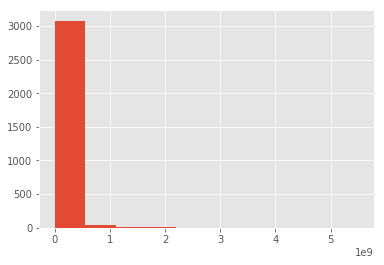

In [4]:
df_funds_sum['Q1 2017 SALES'].hist()

In [ ]:
p = Process_Data()
p.df = df_funds_sum[df_funds_sum['Broad Category Group']=='Allocation']
p._pca()
p._tsne()

In [ ]:
p._plot_lower_dims(dim_red='pca')

In [ ]:
tsne_one = p.df_tsne['pca_one']
tsne_two = p.df_tsne['pca_two']
plt.scatter(tsne_one.values, tsne_two.values)

In [ ]:
p.df_tsne.head()

In [ ]:
sns.lmplot(x='pca_one', y ='pca_two', data = p.df_tsne, hue = 'Morningstar Category', fit_reg=False)

In [ ]:
p2 = Process_Data()
p2.df = df_funds_sum
p2._pca()
p2._tsne()

In [ ]:
sns.lmplot(x='pca_one', y ='pca_two', data = p2.df_tsne, hue = 'Morningstar Category', fit_reg=False, legend=False)

# try:
- using 3 dims for tsne
- % diff

In [ ]:
'''
Find tsne for numerical columns
Output: assign for self.df_tsne a copy of input dataframe with
tsne columns appended
'''
tsne3 = TSNE(n_components = 3)
df_tsne3 = df_funds_sum.copy()
#use only the numeric columns
numerical_df = df_tsne3.select_dtypes(include=[np.number])

tsne_result3 = tsne3.fit_transform(numerical_df.values)


In [ ]:
df_tsne3['tsne_one'] = tsne_result3[:,0]
df_tsne3['tsne_two'] = tsne_result3[:,1]
df_tsne3['tsne_three'] = tsne_result3[:,2]
df_tsne3.head()

In [ ]:
# sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne3, hue = 'Morningstar Category', fit_reg=False)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
colors = df_tsne3['Morningstar Category'].values
ax.scatter(df_tsne3['tsne_one'], df_tsne3['tsne_two'], df_tsne3['tsne_three'], s=60)
ax.view_init(30, 185)
plt.show()

# convert the fund sales/reds to % change

In [ ]:
df_funds_sum.columns

In [ ]:
df_funds_sum.head()
def make_pct_change(df, list_col_names_to_change):
    '''
   
    '''
    # Filter the dataframe to just the columns to change
    df=df.copy()
    df_to_change = df.loc[:,list_col_names_to_change]
    num_columns = df_to_change.shape[1]
    
    # got through columns t+1 to end
    for col_idx in np.arange(1,num_columns):
        col_name = ('{} % Change'.format(df_to_change.iloc[:,col_idx].name))
        df[col_name]=(df_to_change.iloc[:,col_idx]-df_to_change.iloc[:,col_idx-1])/df_to_change.iloc[:,col_idx-1]
    
    return df

In [ ]:
df_funds_pct_change = make_pct_change(df_funds_sum, ['Q1 2017 SALES', 'Q2 2017 SALES','Q3 2017 SALES', 'Q4 2017 SALES'])
# drop the raw columns
df_funds_pct_change.drop(['Q1 2017 SALES', 'Q2 2017 SALES',
       'Q3 2017 SALES', 'Q4 2017 SALES', 'R4Q Total'], axis=1, inplace=True)
# deal with infinite and nan entries caused by dividing by 0 or a very small amount
df_funds_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)
df_funds_pct_change.fillna(0, inplace=True)
df_funds_pct_change.head()

In [ ]:
df_funds_pct_change.describe()

In [ ]:
tsne_pct = TSNE(n_components = 2)
df_tsne_pct = df_funds_pct_change.copy()
#use only the numeric columns
numerical_df = df_tsne_pct.select_dtypes(include=[np.number])

tsne_result_pct = tsne_pct.fit_transform(numerical_df.values)

In [ ]:
df_tsne_pct['tsne_one'] = tsne_result_pct[:,0]
df_tsne_pct['tsne_two'] = tsne_result_pct[:,1]
df_tsne_pct.head()

In [ ]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_pct, hue = 'Morningstar Category', fit_reg=False, legend=False)

In [5]:
df_bd = df_cusip_bd.groupby(['FDS Broker Name', 'FDS Broker ID']).sum()
df_bd = df_bd.reset_index()
df_bd = df_bd[df_bd.iloc[:,-4:].sum(axis=1)>=1000000]
df_bd.head()

,FDS Broker Name,FDS Broker ID,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES
1,1914 ADVISORS,LMS05640,4.542257e+06,4.533149e+06,3.083544e+06,3.495989e+06
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,1.573542e+06,1.483381e+06,3.486105e+06,1.406448e+06
3,1ST GLOBAL CAPITAL CORP.,LMS00050,1.603425e+08,1.163560e+08,1.049091e+08,1.180875e+08
9,"ABACUS INVESTMENTS, INC.",LMS00290,6.319437e+05,3.562497e+05,5.026831e+05,2.847062e+05
15,ACA/PRUDENT INVESTORS PLANNING CORPORATION,LMS00410,2.709932e+06,6.552936e+05,1.283585e+06,1.257478e+06


In [6]:
tsne_bd = TSNE(n_components = 2)
df_tsne_bd = df_bd.copy()
#use only the numeric columns
numerical_df = df_bd.select_dtypes(include=[np.number])
tsne_result_bd = tsne_bd.fit_transform(numerical_df.values)

In [7]:
df_tsne_bd['tsne_one'] = tsne_result_bd[:,0]
df_tsne_bd['tsne_two'] = tsne_result_bd[:,1]
df_tsne_bd.head()

,FDS Broker Name,FDS Broker ID,Q1 2017 SALES,Q2 2017 SALES,Q3 2017 SALES,Q4 2017 SALES,tsne_one,tsne_two
1,1914 ADVISORS,LMS05640,4.542257e+06,4.533149e+06,3.083544e+06,3.495989e+06,-3.305495,15.003006
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,1.573542e+06,1.483381e+06,3.486105e+06,1.406448e+06,7.578774,1.502201
3,1ST GLOBAL CAPITAL CORP.,LMS00050,1.603425e+08,1.163560e+08,1.049091e+08,1.180875e+08,-30.997513,-28.672800
9,"ABACUS INVESTMENTS, INC.",LMS00290,6.319437e+05,3.562497e+05,5.026831e+05,2.847062e+05,42.011662,-5.913361
15,ACA/PRUDENT INVESTORS PLANNING CORPORATION,LMS00410,2.709932e+06,6.552936e+05,1.283585e+06,1.257478e+06,18.772490,1.282723


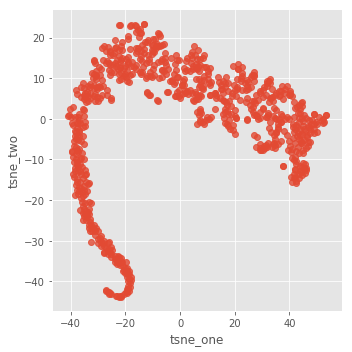

In [8]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_bd, fit_reg=False, legend=False)

In [60]:
# df_bd_mstar_Q4 = 
df_bd_mstar = df_cusip_bd_fundid.groupby(['FDS Broker Name','FDS Broker ID', 'Morningstar Category']).sum()
df_bd_mstar = df_bd_mstar.reset_index()
df_bd_mstar.drop('Rating', axis=1, inplace=True)
df_bd_mstar.head()

df_bd_mstar2 = pd.pivot_table(df_bd_mstar, index=['FDS Broker Name','FDS Broker ID'], \
                              values = 'Q4 2017 SALES', fill_value=0,columns = 'Morningstar Category',\
                              aggfunc = 'sum')
df_bd_mstar2 = df_bd_mstar2.reset_index()
df_bd_mstar2.head()


Morningstar Category,FDS Broker Name,FDS Broker ID,US Fund Allocation--15% to 30% Equity,US Fund Allocation--30% to 50% Equity,US Fund Allocation--50% to 70% Equity,US Fund Allocation--70% to 85% Equity,US Fund Allocation--85%+ Equity,US Fund Bank Loan,US Fund Bear Market,US Fund China Region,US Fund Commodities Broad Basket,US Fund Communications,US Fund Consumer Cyclical,US Fund Consumer Defensive,US Fund Convertibles,US Fund Corporate Bond,US Fund Diversified Emerging Mkts,US Fund Diversified Pacific/Asia,US Fund Emerging Markets Bond,US Fund Emerging-Markets Local-Currency Bond,US Fund Energy Limited Partnership,US Fund Equity Energy,US Fund Equity Precious Metals,US Fund Europe Stock,US Fund Financial,US Fund Foreign Large Blend,US Fund Foreign Large Growth,US Fund Foreign Large Value,US Fund Foreign Small/Mid Blend,US Fund Foreign Small/Mid Growth,US Fund Foreign Small/Mid Value,US Fund Global Real Estate,US Fund Health,US Fund High Yield Bond,US Fund High Yield Muni,US Fund India Equity,US Fund Industrials,US Fund Inflation-Protected Bond,US Fund Infrastructure,US Fund Intermediate Government,US Fund Intermediate-Term Bond,US Fund Japan Stock,US Fund Large Blend,US Fund Large Growth,US Fund Large Value,US Fund Latin America Stock,US Fund Long Government,US Fund Long-Short Credit,US Fund Long-Short Equity,US Fund Long-Term Bond,US Fund Managed Futures,US Fund Market Neutral,US Fund Mid-Cap Blend,US Fund Mid-Cap Growth,US Fund Mid-Cap Value,US Fund Miscellaneous Region,US Fund Multialternative,US Fund Multicurrency,US Fund Multisector Bond,US Fund Muni California Intermediate,US Fund Muni California Long,US Fund Muni Massachusetts,US Fund Muni Minnesota,US Fund Muni National Interm,US Fund Muni National Long,US Fund Muni National Short,US Fund Muni New Jersey,US Fund Muni New York Intermediate,US Fund Muni New York Long,US Fund Muni Ohio,US Fund Muni Pennsylvania,US Fund Muni Single State Interm,US Fund Muni Single State Long,US Fund Muni Single State Short,US Fund Natural Resources,US Fund Nontraditional Bond,US Fund Options-based,US Fund Pacific/Asia ex-Japan Stk,US Fund Preferred Stock,US Fund Real Estate,US Fund Short Government,US Fund Short-Term Bond,US Fund Small Blend,US Fund Small Growth,US Fund Small Value,US Fund Tactical Allocation,US Fund Target-Date 2000-2010,US Fund Target-Date 2015,US Fund Target-Date 2020,US Fund Target-Date 2025,US Fund Target-Date 2030,US Fund Target-Date 2035,US Fund Target-Date 2040,US Fund Target-Date 2045,US Fund Target-Date 2050,US Fund Target-Date 2055,US Fund Target-Date 2060+,US Fund Target-Date Retirement,US Fund Technology,US Fund Ultrashort Bond,US Fund Utilities,US Fund World Allocation,US Fund World Bond,US Fund World Large Stock,US Fund World Small/Mid Stock
0,1717 CAPITAL MANAGEMENT COMPANY,LMS58260,0.00,0.00,225.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,1833.44,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,420.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,300.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,420.00,480.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,480.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1914 ADVISORS,LMS05640,0.00,15000.00,27330.66,6981.61,0.00,0.0,0.0,0.0,390.18,0.00,0.0,0,0.0,22514.90,57039.72,0.0,25678.98,0.00,14095.00,0.00,3297.96,0.00,0.0,22909.72,124978.75,0.00,0.0,0.00,0.0,172.42,0.00,91610.48,164567.0,0.0,0.0,0.00,0.0,0.0,4656.57,0.0,409754.20,198256.18,270782.51,0.0,0.0,0.0,333524.59,0.0,0.0,0.0,695.14,0.00,76150.00,0.0,0.00,0.0,425505.65,0.0,0.00,0.0,0.0,190000.00,95000.00,20000.00,0.0,0.0,0.0,0.0,111594.88,0.0,0.0,0.0,0.00,263500.0,0.0,0.0,46150.0,57941.75,0.00,16741.04,10000.00,25695.13,10618.72,69900.00,0.00,394.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,427.34,0.00,0.0,5000.00,2256.97,0.00,155977.00,955.20,79783.99,38159.83
2,"1ST DISCOUNT BROKERAGE, INC.",LMS00040,0

In [61]:
tsne_bd_mstar = TSNE(n_components = 2)
df_tsne_bd_mstar = df_bd_mstar2.copy()
#use only the numeric columns
numerical_df = df_bd_mstar2.select_dtypes(include=[np.number])
tsne_result_bd_mstar = tsne_bd_mstar.fit_transform(numerical_df.values)

df_tsne_bd_mstar['tsne_one'] = tsne_result_bd_mstar[:,0]
df_tsne_bd_mstar['tsne_two'] = tsne_result_bd_mstar[:,1]
df_tsne_bd_mstar.head()

Morningstar Category,FDS Broker Name,FDS Broker ID,US Fund Allocation--15% to 30% Equity,US Fund Allocation--30% to 50% Equity,US Fund Allocation--50% to 70% Equity,US Fund Allocation--70% to 85% Equity,US Fund Allocation--85%+ Equity,US Fund Bank Loan,US Fund Bear Market,US Fund China Region,US Fund Commodities Broad Basket,US Fund Communications,US Fund Consumer Cyclical,US Fund Consumer Defensive,US Fund Convertibles,US Fund Corporate Bond,US Fund Diversified Emerging Mkts,US Fund Diversified Pacific/Asia,US Fund Emerging Markets Bond,US Fund Emerging-Markets Local-Currency Bond,US Fund Energy Limited Partnership,US Fund Equity Energy,US Fund Equity Precious Metals,US Fund Europe Stock,US Fund Financial,US Fund Foreign Large Blend,US Fund Foreign Large Growth,US Fund Foreign Large Value,US Fund Foreign Small/Mid Blend,US Fund Foreign Small/Mid Growth,US Fund Foreign Small/Mid Value,US Fund Global Real Estate,US Fund Health,US Fund High Yield Bond,US Fund High Yield Muni,US Fund India Equity,US Fund Industrials,US Fund Inflation-Protected Bond,US Fund Infrastructure,US Fund Intermediate Government,US Fund Intermediate-Term Bond,US Fund Japan Stock,US Fund Large Blend,US Fund Large Growth,US Fund Large Value,US Fund Latin America Stock,US Fund Long Government,US Fund Long-Short Credit,US Fund Long-Short Equity,US Fund Long-Term Bond,US Fund Managed Futures,US Fund Market Neutral,US Fund Mid-Cap Blend,US Fund Mid-Cap Growth,US Fund Mid-Cap Value,US Fund Miscellaneous Region,US Fund Multialternative,US Fund Multicurrency,US Fund Multisector Bond,US Fund Muni California Intermediate,US Fund Muni California Long,US Fund Muni Massachusetts,US Fund Muni Minnesota,US Fund Muni National Interm,US Fund Muni National Long,US Fund Muni National Short,US Fund Muni New Jersey,US Fund Muni New York Intermediate,US Fund Muni New York Long,US Fund Muni Ohio,US Fund Muni Pennsylvania,US Fund Muni Single State Interm,US Fund Muni Single State Long,US Fund Muni Single State Short,US Fund Natural Resources,US Fund Nontraditional Bond,US Fund Options-based,US Fund Pacific/Asia ex-Japan Stk,US Fund Preferred Stock,US Fund Real Estate,US Fund Short Government,US Fund Short-Term Bond,US Fund Small Blend,US Fund Small Growth,US Fund Small Value,US Fund Tactical Allocation,US Fund Target-Date 2000-2010,US Fund Target-Date 2015,US Fund Target-Date 2020,US Fund Target-Date 2025,US Fund Target-Date 2030,US Fund Target-Date 2035,US Fund Target-Date 2040,US Fund Target-Date 2045,US Fund Target-Date 2050,US Fund Target-Date 2055,US Fund Target-Date 2060+,US Fund Target-Date Retirement,US Fund Technology,US Fund Ultrashort Bond,US Fund Utilities,US Fund World Allocation,US Fund World Bond,US Fund World Large Stock,US Fund World Small/Mid Stock,tsne_one,tsne_two
0,1717 CAPITAL MANAGEMENT COMPANY,LMS58260,0.00,0.00,225.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0,0.0,0.00,1833.44,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,420.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,300.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,420.00,480.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,480.00,0.00,0.00,0.00,0.00,0.00,0.00,15.110941,-12.256586
1,1914 ADVISORS,LMS05640,0.00,15000.00,27330.66,6981.61,0.00,0.0,0.0,0.0,390.18,0.00,0.0,0,0.0,22514.90,57039.72,0.0,25678.98,0.00,14095.00,0.00,3297.96,0.00,0.0,22909.72,124978.75,0.00,0.0,0.00,0.0,172.42,0.00,91610.48,164567.0,0.0,0.0,0.00,0.0,0.0,4656.57,0.0,409754.20,198256.18,270782.51,0.0,0.0,0.0,333524.59,0.0,0.0,0.0,695.14,0.00,76150.00,0.0,0.00,0.0,425505.65,0.0,0.00,0.0,0.0,190000.00,95000.00,20000.00,0.0,0.0,0.0,0.0,111594.88,0.0,0.0,0.0,0.00,263500.0,0.0,0.0,46150.0,57941.75,0.00,16741.04,10000.00,25695.13,10618.72,69900.00,0.00,394.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,427.34,0.00,0.0,5000.00,2256.97,0.00,155977.00,955.20,79783.99,38159.83,4.42

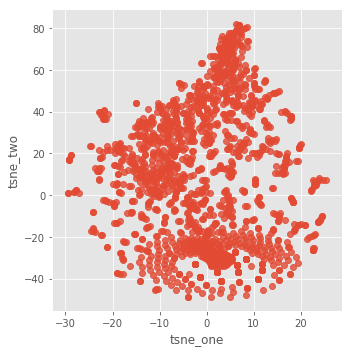

In [62]:
sns.lmplot(x='tsne_one', y ='tsne_two', data = df_tsne_bd_mstar, fit_reg=False)

In [ ]:
# Try to take out the time component

In [ ]:
# try clustering in high-dimensional space.
# feature engineer so that jan fun 1- avg jan all funds
# dynamic time warping - use dtw as the distance metric hierachical clustering lecture
# 

# Results day 1
data processing minimal Nan->0
pca - no pattern
tsne - warpy thing, mostly picking up on time?

tried:
    - 3 component tsne: no better
    - % diff QoQ: no better
    
  goals: remove the time cycle component